# 📰 News‑Headline Clustering & Exploration  
In this notebook we will

1. Ingest a headline + body dataset  
2. Turn every headline into a dense, semantic embedding (768‑D)  
3. Compress those embeddings to 2‑D with UMAP for visual inspection  
4. Cluster the compressed points with K‑Means  
5. Inspect clusters with interactive scatterplots & word‑clouds  
6. (Optionally) map numeric cluster labels to human‑readable topic names

In [ ]:
import pandas as pd
import numpy as np
import umap
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer

### Why these libraries?

* **SentenceTransformer** (all‑mpnet‑base‑v2) → state‑of‑the‑art sentence embeddings  
* **UMAP** → non‑linear, distance‑preserving 2‑D projection (better than t‑SNE for large datasets)  
* **KMeans** → fast, well‑understood clustering baseline  
* **Plotly** → interactive scatter; hover reveals each headline  
* **WordCloud** → quick glance at cluster vocabulary


In [ ]:
df=pd.read_csv('../datasets/dataset.csv')
df.head()

Heading  \
0  free speech not hate speech madras high court ...   
1  comment take context say us cop mock indian st...   
2  first meeting one nation one election committe...   
3  us airlines flight depressurize midair plummet...   
4  terrorist kill security force foil infiltratio...   

                                                Body  \
0  madras high court issue significant remark ami...   
1  seattle police officer guild friday come defen...   
2  first official meeting one nation one election...   
3  united airlines jet head rome turn around less...   
4  three terrorist kill infiltration bid foil sec...   

                                                 URL  
0  https://www.indiatoday.in/law/high-courts/stor...  
1  https://www.indiatoday.in/world/story/indian-s...  
2  https://www.indiatoday.in/india/story/one-nati...  
3  https://www.indiatoday.in/world/story/us-fligh...  
4  https://www.indiatoday.in/india/story/one-terr...

* **Columns**  
  * `Heading` – the news headline (we will embed this)  
  * `Body`    – the article snippet / story body (handy for later analysis)  
  * `URL`     – original source (kept for traceability)  

* **Scale**  
  * 11 583 headlines give us enough variety to discover meaningful clusters


In [3]:
df.shape

(11583, 3)

In [4]:
corpus=list(df['Heading'])
corpus[8775]

The `corpus` list will feed straight into the SentenceTransformer model.

In [ ]:
embedder = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embeddings = embedder.encode(corpus)
print(embeddings)

In [ ]:
np.save('../datasets/embeddings_headings.npy', embeddings)

In [ ]:
corpus_embeddings=np.load('../datasets/embeddings_headings.npy')
print(corpus_embeddings.shape)

(11583, 768)


* Each headline ➜ **768‑length** vector in MPNet’s semantic space  
* Stored to disk so we don’t have to recompute later  
* 768 × 11 583 ≈ 8.9 M values ⇒ ~34 MB on disk as `float32`


In [6]:
# reduce the size of the embeddings using UMAP
reduced_embeddings = umap.UMAP(n_components=2, n_neighbors=100, min_dist=0.02).fit_transform(corpus_embeddings)
print(reduced_embeddings.shape)

# put the values of the two dimensions inside the dataframe
df["x"] = reduced_embeddings[:, 0]
df["y"] = reduced_embeddings[:, 1]

# substring of the full text, for visualization purposes
df["text_short"] = df["Heading"].str[:100]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(11583, 2)


UMAP tries to keep neighbours in 768‑D **close** in 2‑D so we can _see_ semantic neighbourhoods.  
The hyper‑parameters above were tuned empirically to give fairly distinct islands.


In [7]:
reduced_embeddings

array([[ 3.0888836, 12.935019 ],
       [ 4.197543 , 12.707436 ],
       [ 1.0901866, 13.899552 ],
       ...,
       [ 1.6690639, 13.591404 ],
       [ 6.9892263, 10.174538 ],
       [ 2.891452 , 12.416494 ]], dtype=float32)

In [8]:
# scatter plot
hover_data = {
    "text_short": True,
    "x": False,
    "y": False
}
fig = px.scatter(df, x="x", y="y", template="plotly_dark",
                   title="Embeddings", hover_data=hover_data)
fig.update_layout(showlegend=False)
fig.show()

**Interpretation:**  
Zoom & pan to explore. Headlines that land in tight pockets tend to talk about the same story or topic. Sparse regions indicate niche or noisy content.


In [9]:
num_clusters=10
clustering_model=KMeans(n_clusters=num_clusters)
clustering_model.fit(reduced_embeddings)
cluster_assignment=clustering_model.labels_

In [10]:
cluster_assignment

array([0, 3, 6, ..., 6, 4, 0], dtype=int32)

Choosing *k = 10* is subjective; it roughly matches broad news desks  
(Politics, Sports, Tech, Crime, …). Feel free to tweak and compare inertia.


In [11]:
cluster_df = pd.DataFrame(corpus, columns = ['corpus'])
cluster_df['cluster'] = cluster_assignment
cluster_df.head()

corpus  cluster
0  free speech not hate speech madras high court ...        0
1  comment take context say us cop mock indian st...        3
2  first meeting one nation one election committe...        6
3  us airlines flight depressurize midair plummet...        3
4  terrorist kill security force foil infiltratio...        3

In [12]:
desired_cluster = 0
selected_df = cluster_df[cluster_df['cluster'] == desired_cluster]
selected_df.head(15)

corpus  cluster
0    free speech not hate speech madras high court ...        0
5    probe agency summon tiger shroff sunny leone l...        0
7    vivek ramaswamy paranoid leader treat employee...        0
19   not lecture mohabbat congress respond anurag t...        0
25                                       editorinchief        0
28                 telgi story everyone love good scam        0
45         india today archive jinnah antihero freedom        0
48   irresponsible derek obrien write jaishankar su...        0
51   noncooperation movement hatred india bloc deci...        0
53   childish assam chief minister himanta sarma sl...        0
74   mastercard india appoint former sbi chief rajn...        0
84   bp ceo bernard looney resign abruptly transpar...        0
109  man click big bazaar special discount ad socia...        0
110  google continue track user location without co...        0
111  exgoogle employee say nothing guarantee lose j...        0

In [13]:
selected_df.shape

(1422, 2)

In [15]:
def word_cloud(pred_df,label):
    wc = ' '.join([text for text in pred_df['corpus'][pred_df['cluster'] == label]])
    wordcloud = WordCloud(width=800, height=500,
    random_state=21, max_font_size=110).generate(wc)
    fig7 = plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')

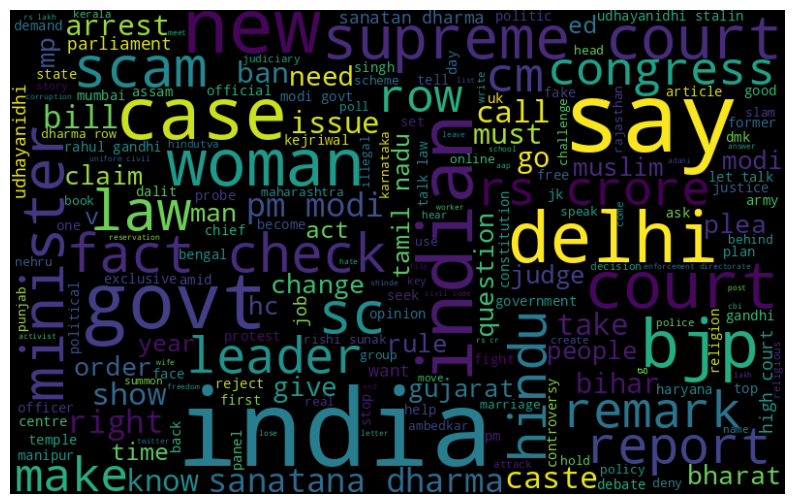

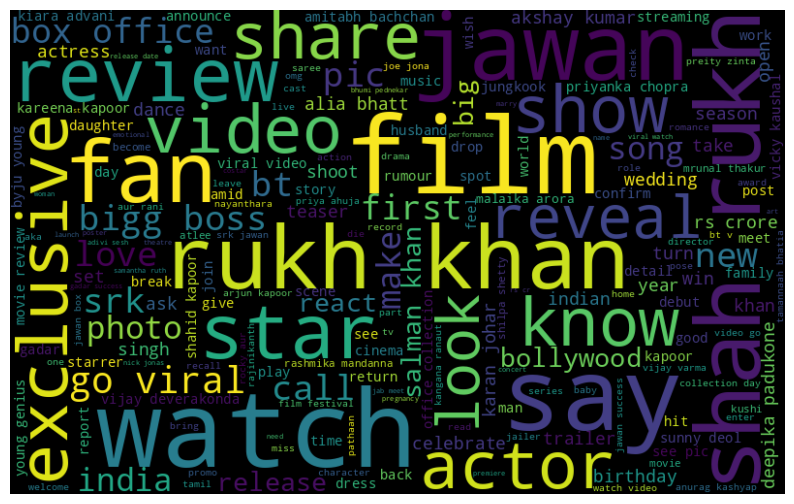

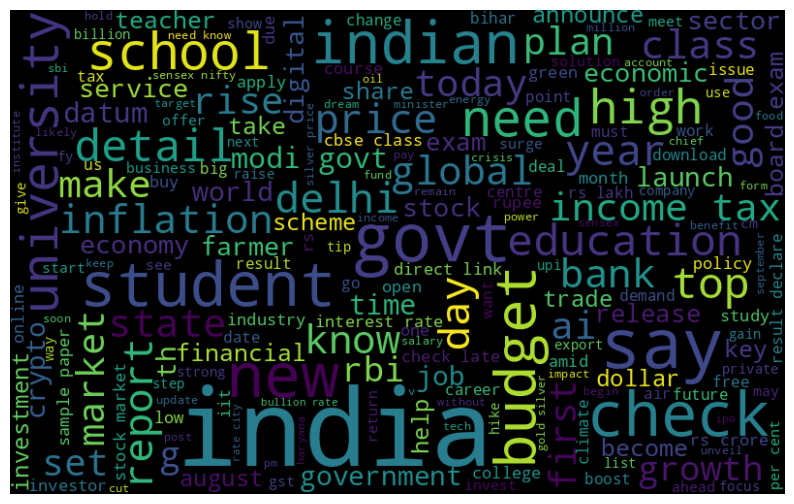

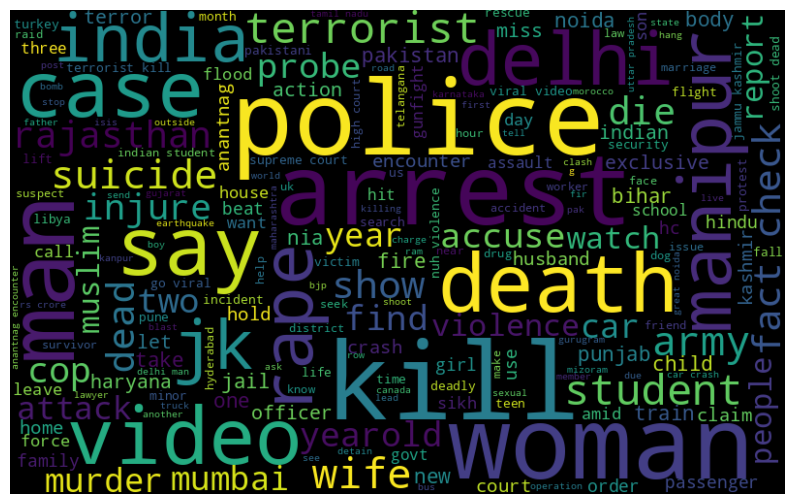

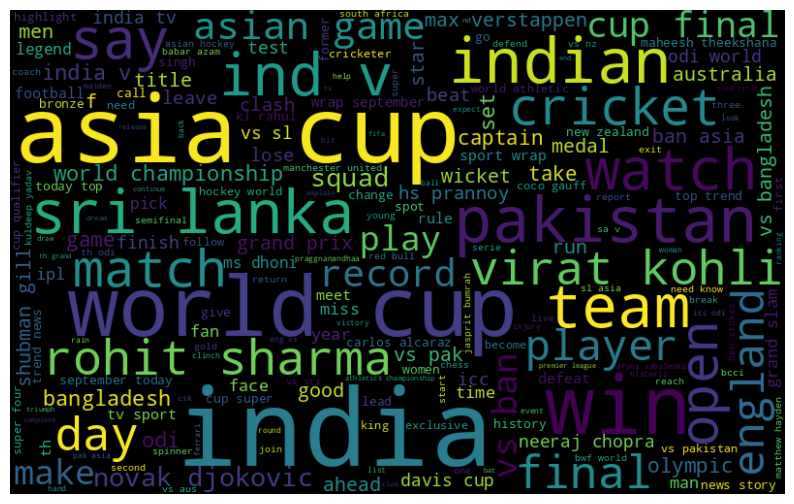

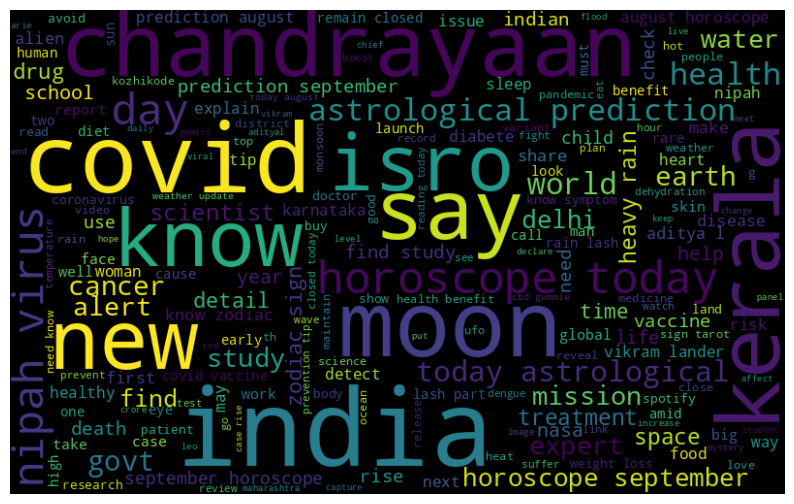

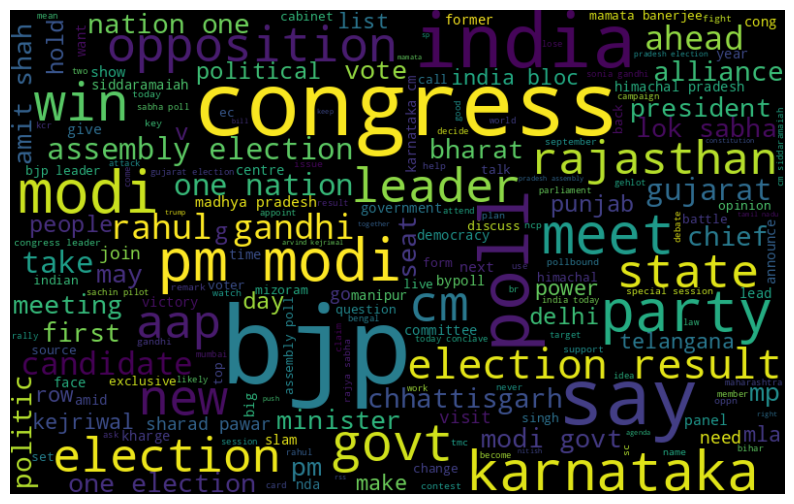

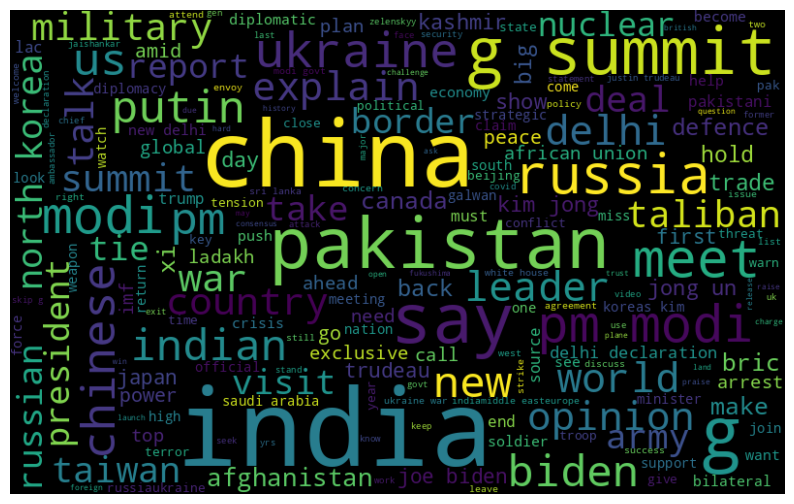

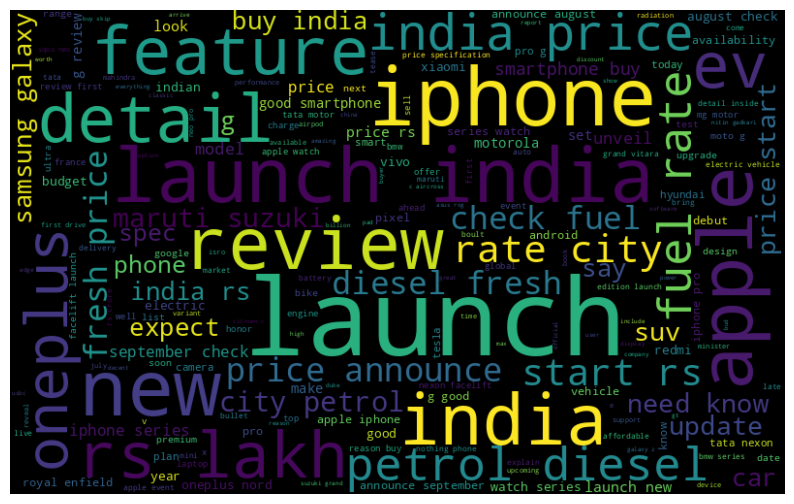

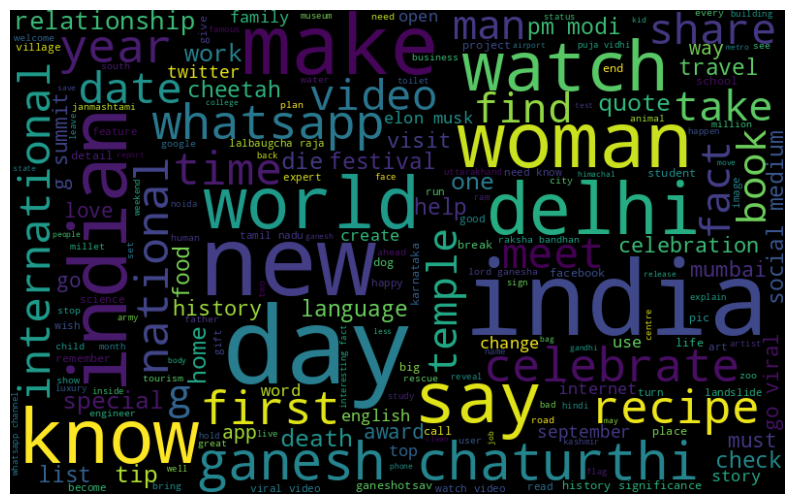

In [16]:
for i in range(10):
    word_cloud(cluster_df,i)

These word‑clouds help us decide what each numeric label actually represents.


In [17]:
def categorize(label):
    if label==3:
        return 'Judiciary'
    elif label==9:
        return 'Entertainment'
    elif label==4:
        return 'Science'
    elif label==5:
        return 'Sports'
    elif label==8:
        return 'Politics'
    elif label==0:
        return 'International'
    elif label==7:
        return 'Technology'
    elif label==2:
        return 'Business'
    elif label==1:
        return 'Culture'
    elif label==6:
        return 'Crime'
    else:
        return label

The mapping above is **hand‑crafted** after inspecting clusters.  
If your own run shuffles cluster IDs, revisit the word‑clouds and edit the dictionary.


In [18]:
cluster_df['Body']=df['Body']
cluster_df.head()

corpus  cluster  \
0  free speech not hate speech madras high court ...        0   
1  comment take context say us cop mock indian st...        3   
2  first meeting one nation one election committe...        6   
3  us airlines flight depressurize midair plummet...        3   
4  terrorist kill security force foil infiltratio...        3   

                                                Body  
0  madras high court issue significant remark ami...  
1  seattle police officer guild friday come defen...  
2  first official meeting one nation one election...  
3  united airlines jet head rome turn around less...  
4  three terrorist kill infiltration bid foil sec...

In [19]:
cluster_df['Category'] = cluster_df['cluster'].apply(categorize)
pd.unique(cluster_df['Category'])

array(['International', 'Judiciary', 'Crime', 'Sports', 'Culture',
       'Science', 'Entertainment', 'Technology', 'Business', 'Politics'],
      dtype=object)

In [20]:
cluster_df.head()

corpus  cluster  \
0  free speech not hate speech madras high court ...        0   
1  comment take context say us cop mock indian st...        3   
2  first meeting one nation one election committe...        6   
3  us airlines flight depressurize midair plummet...        3   
4  terrorist kill security force foil infiltratio...        3   

                                                Body       Category  
0  madras high court issue significant remark ami...  International  
1  seattle police officer guild friday come defen...      Judiciary  
2  first official meeting one nation one election...          Crime  
3  united airlines jet head rome turn around less...      Judiciary  
4  three terrorist kill infiltration bid foil sec...      Judiciary

In [21]:
del cluster_df['cluster']
cluster_df.head()

corpus  \
0  free speech not hate speech madras high court ...   
1  comment take context say us cop mock indian st...   
2  first meeting one nation one election committe...   
3  us airlines flight depressurize midair plummet...   
4  terrorist kill security force foil infiltratio...   

                                                Body       Category  
0  madras high court issue significant remark ami...  International  
1  seattle police officer guild friday come defen...      Judiciary  
2  first official meeting one nation one election...          Crime  
3  united airlines jet head rome turn around less...      Judiciary  
4  three terrorist kill infiltration bid foil sec...      Judiciary

In [22]:
cluster_df.rename(columns={'corpus': 'Heading'}, inplace=True)
cluster_df.head()

Heading  \
0  free speech not hate speech madras high court ...   
1  comment take context say us cop mock indian st...   
2  first meeting one nation one election committe...   
3  us airlines flight depressurize midair plummet...   
4  terrorist kill security force foil infiltratio...   

                                                Body       Category  
0  madras high court issue significant remark ami...  International  
1  seattle police officer guild friday come defen...      Judiciary  
2  first official meeting one nation one election...          Crime  
3  united airlines jet head rome turn around less...      Judiciary  
4  three terrorist kill infiltration bid foil sec...      Judiciary

In [23]:
cluster_df['URL']=df['URL']
cluster_df.head()

Heading  \
0  free speech not hate speech madras high court ...   
1  comment take context say us cop mock indian st...   
2  first meeting one nation one election committe...   
3  us airlines flight depressurize midair plummet...   
4  terrorist kill security force foil infiltratio...   

                                                Body       Category  \
0  madras high court issue significant remark ami...  International   
1  seattle police officer guild friday come defen...      Judiciary   
2  first official meeting one nation one election...          Crime   
3  united airlines jet head rome turn around less...      Judiciary   
4  three terrorist kill infiltration bid foil sec...      Judiciary   

                                                 URL  
0  https://www.indiatoday.in/law/high-courts/stor...  
1  https://www.indiatoday.in/world/story/indian-s...  
2  https://www.indiatoday.in/india/story/one-nati...  
3  https://www.indiatoday.in/world/story/us-fligh...  
4  https://www.indiatoday.in/india/story/one-terr...

In [ ]:
cluster_df.to_csv('labelled.csv', index=False)

In [ ]:
# prompt: save the model and the mapping of the clusters

import joblib

# Assuming 'clustering_model' is your trained KMeans model
joblib.dump(clustering_model, 'clustering_model.pkl')
